# LSE ST451: Bayesian Machine Learning
## Author: Kostas Kalogeropoulos

## Week 3: Baysian Linear Regression part II

Topics covered 
 - Creating your own function in Python
 - Performing matrix operations
 - Conducting full MLE analysis, with confidence intervals rather than just point estimates for the regression coefficients
 - Fitting Bayesian Linear Regression models and summarising the posterior of the regressions coefficients
 - Calculate the marginal likelihood / model evidence for linear regression models to perform Bayesian model selection

We begin with loading the necessary libraries. We will pretty much the same libraries as next week with three additions: **scipy** for matrix operations, **seaborn** for better looking plots and **statsmodels** for full linear regression output

In [66]:
import numpy as np             
import pandas as pd  #Python Data Analysis Library handle data in a user friendly way
import scipy as sc
import matplotlib.pyplot as plt #for plots
import seaborn as sns # for better plots
%matplotlib inline
from sklearn import linear_model # A very popular Python library for Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #needed to for assessing prediction
from sklearn import datasets ## imports datasets from scikit-learn
import statsmodels.api as sm

We will begin with the polynomial example of last week. We will sumlate 20 points this time

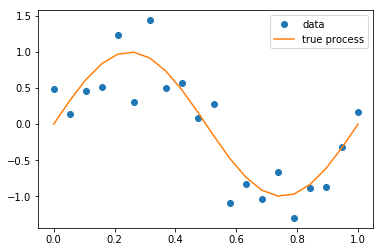

In [28]:
#Polynomial fitting exercises
np.random.seed(1)
n = 20 #number of points
x = np.linspace(0, 1, n)
f = np.sin(2*np.pi*x)
y = f+0.3*np.random.randn(n)
#plt.plot(xg,f,label='true process')
plt.plot(x,y,'o',label='data')
plt.plot(x,f,label='true process')
plt.legend()

In [29]:
#put x,y into the pandas dataframe called data. also put a vector of ones as x0
x0 = np.ones(n)
data = pd.DataFrame(np.column_stack([y,x0,x]),columns=['y','x0','x']) 
#Expand the data including powers of x up to 10
for i in range(2,11):  #executes the following indented commands for i varying from 3 to 9
    colname = 'x%d'%i # the %d %i puts a different number in the name of each variable
    data[colname] = data['x']**i #raise to the power of i
    # the for loop continues until the first time a command is not indented.
data.head()

,y,x0,x,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0.487304,1.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.141173,1.0,0.052632,0.002770,0.000146,0.000008,4.038611e-07,2.125585e-08,1.118729e-09,5.888046e-11,3.098972e-12,1.631038e-13
2,0.455761,1.0,0.105263,0.011080,0.001166,0.000123,1.292355e-05,1.360374e-06,1.431973e-07,1.507340e-08,1.586673e-09,1.670183e-10
3,0.515276,1.0,0.157895,0.024931,0.003936,0.000622,9.813824e-05,1.549551e-05,2.446660e-06,3.863147e-07,6.099706e-08,9.631114e-09
4,1.229023,1.0,0.210526,0.044321,0.009331,0.001964,4.135537e-04,8.706395e-05,1.832925e-05,3.858790e-06,8.123768e-07,1.710267e-07


Note that we added x0 a vector of ones for the constant in the regression equation. This will be handy for the matrix operations.

It doesn't affect what we were doing last time though. The code below gives us the same output

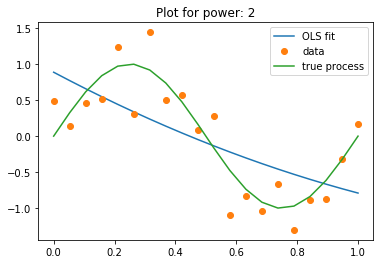

In [30]:
npower = 2
predictors = ['x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
linreg = LinearRegression(fit_intercept=True,normalize=False)
linreg.fit(data[predictors],data['y'])
y_pred = linreg.predict(data[predictors])
plt.plot(data['x'],y_pred, label='OLS fit')
plt.plot(data['x'],data['y'],'o',label='data')
plt.plot(x,f,label='true process')
plt.title('Plot for power: %d'%npower)
plt.legend()

### Matrix operations

Below we find the MLE without the scikit linear regression function. For that we

1. Form the design matrix $X$ and the response vector y
2. Calculate the MLE as $$\hat{\beta} = (X^T X)^{-1}X^T y$$

The code below does that and also prints $X^T X$ and $(X^T X)^{-1}$ for checking.

In [31]:
npower = 2
predictors = ['x0','x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
X = data[predictors]
y = data['y']
XtX = X.T.dot(X) #X.T give X transpose X.dot(b) does matrix multiplication X*b
XtX_inv = sc.linalg.inv(XtX) #sc.linalg.inv(A) provide the inverse of A
beta = XtX_inv.dot(X.T.dot(y))
XtX, XtX_inv, beta

(           x0          x        x2
 x0  20.000000  10.000000  6.842105
 x   10.000000   6.842105  5.263158
 x2   6.842105   5.263158  4.317539,
 array([[ 0.37077922, -1.44350649,  1.17207792],
        [-1.44350649,  7.96601732, -7.42316017],
        [ 1.17207792, -7.42316017,  7.42316017]]),
 array([ 0.88516511, -2.23262046,  0.55870444]))

Check the MLE found previously with the scikit function

In [32]:
linreg = LinearRegression(fit_intercept=True,normalize=False)
predictors = ['x','x2']
linreg.fit(data[predictors],data['y'])
beta = [linreg.intercept_]
beta.extend(linreg.coef_)
beta

[0.8851651079530483, -2.2326204575101936, 0.5587044411404251]

We can go beyond the point estimate and calculate the variance of $\hat{\beta}$.

The code below provides $\hat{\sigma}^2$, the covariance matrix $$\mbox{var}[\hat{\beta}] = \hat{\sigma}^2 (X^T X)^{-1}, $$
and its diagonal.

In [33]:
n,p = X.shape
e = y - X.dot(beta)
sigma2_hat = e.T.dot(e)/(n-p)
var_beta = sigma2_hat*(XtX_inv)
sigma2_hat, var_beta, np.diag(var_beta)

(0.3881246982512338, array([[ 0.14390857, -0.56026052,  0.45491239],
        [-0.56026052,  3.09180807, -2.8811118 ],
        [ 0.45491239, -2.8811118 ,  2.8811118 ]]), array([0.14390857, 3.09180807, 2.8811118 ]))

With the above quantities we can calculate confidence intervals for MLE's. For those we will need the 97.5\% point of the $t_{n-p}$ distribution. 

The following code does that and also puts the results in pandas dataframe.

In [34]:
#calculate 95% CI for beta and present output via a pandas data frame 
tval = sc.stats.t.ppf(0.975,n-p)
std_beta = np.sqrt(np.diag(var_beta))
lower95 = beta - tval*std_beta
upper95 = beta + tval*std_beta
results = np.column_stack([beta,std_beta,lower95,upper95])
col = ['coefficient','se','lower 95% bound','upper 95% bound']
ind = ['intercept','x','x2']
results = pd.DataFrame(results,columns = col,index=ind)
results

,coefficient,se,lower 95% bound,upper 95% bound
intercept,0.885165,0.379353,0.084801,1.685530
x,-2.232620,1.758354,-5.942423,1.477182
x2,0.558704,1.697384,-3.022462,4.139871


To check our answers we also use the relevant function (.OLS) of the library **statsmodels**  

In [35]:
predictors = ['x','x2']
X = data[predictors]
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
model.summary()

/Users/kalogerk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     6.704
Date:                Fri, 27 Dec 2019   Prob (F-statistic):            0.00714
Time:                        18:23:26   Log-Likelihood:                -17.289
No. Observations:                  20   AIC:                             40.58
Df Residuals:                      17   BIC:                             43.57
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8852      0.379      2.333      0.032       0.085       1.686
x             -2.2326      1.758     -1.270      0.221      -5.942       1.477
x2             0.5587      1.697      0.329      0.746      -3.022       4.140
==============================================================================
Omnibus:                        1.146   Durbin-Watson:                   1.109
Prob(Omnibus):                  0.564   Jarque-Bera (JB):                1.040
Skew:                           0.412   Prob(JB):                        0.595
Kurtosis:                       2.245   Cond. No.                         20.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Activity 1

1. Obtain the MLEs and 95\% confidence intervals for the 3rd order polynomial without using any Python built in function. 
2. Check your answers against the statsmodels corresponding functions (.OLS)

In [36]:
npower = 3
predictors = ['x0','x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
X = data[predictors]
y = data['y']
XtX = X.T.dot(X) #X.T give X transpose X.dot(b) does matrix multiplication X*b
XtX_inv = sc.linalg.inv(XtX) #sc.linalg.inv(A) provide the inverse of A
beta = XtX_inv.dot(X.T.dot(y))
n,p = X.shape
e = y - X.dot(beta)
sigma2_hat = e.T.dot(e)/(n-p)
var_beta = sigma2_hat*(XtX_inv)
#calculate 95% CI for beta and present output via a pandas data frame 
tval = sc.stats.t.ppf(0.975,n-p)
std_beta = np.sqrt(np.diag(var_beta))
lower95 = beta - tval*std_beta
upper95 = beta + tval*std_beta
results = np.column_stack([beta,std_beta,lower95,upper95])
col = ['coefficient','se','lower 95% bound','upper 95% bound']
ind = ['intercept','x','x2','x3']
results = pd.DataFrame(results,columns = col,index=ind)
results

,coefficient,se,lower 95% bound,upper 95% bound
intercept,-0.010460,0.290987,-0.627324,0.606404
x,10.124663,2.586393,4.641755,15.607572
x2,-31.139397,6.102501,-44.076122,-18.202672
x3,21.132068,4.006810,12.638011,29.626125


In [37]:
predictors = ['x','x2','x3']
X = data[predictors]
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     20.79
Date:                Fri, 27 Dec 2019   Prob (F-statistic):           9.12e-06
Time:                        18:23:37   Log-Likelihood:                -7.2153
No. Observations:                  20   AIC:                             22.43
Df Residuals:                      16   BIC:                             26.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0105      0.291     -0.036      0.972      -0.627       0.606
x             10.1247      2.586      3.915      0.001       4.642      15.608
x2           -31.1394      6.103     -5.103      0.000     -44.076     -18.203
x3            21.1321      4.007      5.274      0.000      12.638      29.626
==============================================================================
Omnibus:                        0.301   Durbin-Watson:                   2.750
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.470
Skew:                           0.142   Prob(JB):                        0.790
Kurtosis:                       2.305   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Writing functions in Python

We will now put all the previous talk into a function. In other words we will create our own function rather than using the stasmodels/scikit learn ones. 

The inputs of the function will be $X$, $y$ and the names of the predictors. The output will be a data frame with the results (MLE's, se's and 95\% CI's)  

In [38]:
#create a function to get MLE of beta, its SE, 95%CIs and present the ouput  
def LRST451(X,y,predictor_names):
    col_names = ['beta','se','lower 95% bound','upper 95% bound']
    XtX = X.T.dot(X)
    XtX_inv = sc.linalg.inv(X.T.dot(X))
    beta = XtX_inv.dot(X.T.dot(y))
    e = y - X.dot(beta)
    n,p = X.shape
    sigma2_hat = e.T.dot(e)/(n-p)
    var_beta = sigma2_hat*(XtX_inv)
    tval = sc.stats.t.ppf(0.975,n-p)
    se_beta = np.sqrt(np.diag(var_beta))
    lower95 = beta - sc.stats.t.ppf(0.975,n-p)*se_beta
    upper95 = beta + sc.stats.t.ppf(0.975,n-p)*se_beta
    results = np.column_stack([beta,se_beta,lower95,upper95])
    results = pd.DataFrame(results,columns = col_names,index=predictor_names)
    return results

This is it, the function is now stored in Python's memory. 

From now on, we will only need to specify X,y predictor_names, and just write 'LRST451(X,y,predictor_names)'. 

In [39]:
#Set up model (X) and y
npower = 4
predictors = ['x0','x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
X = data[predictors]
y = data['y']
results = LRST451(X,y,predictors)
results

,beta,se,lower 95% bound,upper 95% bound
x0,0.189768,0.323815,-0.500426,0.879963
x,4.918562,4.736017,-5.176019,15.013143
x2,-6.297746,20.009958,-48.947962,36.352469
x3,-18.139031,30.443699,-83.028240,46.750177
x4,19.635549,15.094949,-12.538573,51.809672


### Bayesian Linear Regression

We now turn to Bayesian inference. As before we will illustrate and then create a function that provides summaries of the posterior (Bayes estimates of $\beta$ and 95\% Credible Intervals).

We start by calculating the posterior parameters that correspond to the unit information prior.

Given $\sigma^2$ and a **prior** of N($\mu_0,\sigma^2\Omega_0)$, the **posterior** $\pi(\beta|X,y,\sigma^2)$ is N($\mu_n,\sigma^2\Omega_n^2$) where

$$\mu_n = (X^T X+\Omega_0^{-1})^{-1} (\Omega_0^{-1}\mu_0 +X^{T}y)$$
$$\Omega_n =(X^T X +\Omega_0^{-1})^{-1}$$

To assign the unit information prior we set $\Omega_0 = n(X^T X)^{-1}$ or else $\Omega_0^{-1}=X^T X / n$.

For $\sigma^2$ if we set the **prior** IGamma$(a_0,b_0)$ we get the **posterior** IGamma$(a_n,b_n)$ where
$$
a_n = a_0+\frac{n}{2}
$$
$$
b_n = b_0+\frac{1}{2} (y^T y + \mu_0^T\Omega_0^{-1}\mu_0 +\mu_n^T\Omega_n^{-1}\mu_n).
$$

In [40]:
#set up X and y
npower = 3
predictors = ['x0','x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
X = data[predictors]
y = data['y']
n,p = X.shape

#set up prior parameters
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior
a_0 = 0.01
b_0 = 0.01

#calculate posterior parameters
Om_n_inv = XtX + Om_0_inv
Om_n = sc.linalg.inv(Om_n_inv)
term1 = Om_0_inv.dot(mu_0)+X.T.dot(y)
mu_n = Om_n.dot(term1)
a_n = a_0 + n/2
term2 = y.T.dot(y)+mu_0.dot(Om_0_inv.dot(mu_0))-mu_n.dot(Om_n_inv.dot(mu_n))
b_n = b_0 + term2/2

#### Monte Carlo for credible intervals

To obtain credible intervals for $\beta$ we could use the $t$ distribution. But we would use Monte Carlo instead as this will cover more general models. e.g. logistic regression.

So we will sample $N$ Monte Carlo samples from $\pi(\beta|y)$ and use them  for Monte Carlo inference (credible intervals, density plots etc)

Monte Carlo Samples can be drawn by

1. Generating samples $\sigma_i^2$ from IGamma$(\alpha_n,\beta_n)$, $i=1,\dots,N$,
2. Draw $\beta_i$ sample based on each $\sigma_i^2$ from N($\mu_n,\sigma^2\Omega_n^2$)

In [41]:
#Calculate 95% credible intervals
N = 10000 #number of Monte Carlo samples
sigma2 = 1/np.random.gamma(a_n, 1/b_n, N)
betas = np.zeros((N,p))
# draw N samples from the marginal posterior of beta
for i in range(0,N):
    s2 =sigma2[i]
    cov = s2*Om_n
    betas[i,] = np.random.multivariate_normal(mu_n,cov,1)

#find the mean of each column which corresponds to each beta coefficient     
mu_beta = np.mean(betas, axis=0)
#find the 2.5 and 97.5 percentils which correspond to each beta coefficient 
lower95 = np.percentile(betas,2.5,axis=0)
upper95 = np.percentile(betas,97.5,axis=0)
mu_beta, lower95, upper95

(array([-7.63510543e-03,  9.63163549e+00, -2.96368006e+01,  2.01117858e+01]),
 array([ -0.59458124,   4.36736323, -41.71684914,  12.0423543 ]),
 array([  0.58503458,  14.70301061, -17.21143962,  28.13363717]))

As before we put it all in a function. This is quite handy as it is hard to find such a function in Python!!

In [42]:
# function for Bayesian Linear regression, return posterior mean and 95% CIs
def BLR(X,y,mu_0,Om_0_inv,a_0,b_0,ind_names,N):
    col_names = ['posterior mean','lower 95% bound','upper 95% bound']
    n,p = X.shape
    XtX = X.T.dot(X)
    Om_n_inv = XtX + Om_0_inv
    Om_n = sc.linalg.inv(Om_n_inv)
    term1 = Om_0_inv.dot(mu_0)+X.T.dot(y)
    mu_n = Om_n.dot(term1)
    a_n = a_0 + n/2
    term2 = y.T.dot(y)+mu_0.dot(Om_0_inv.dot(mu_0))-mu_n.dot(Om_n_inv.dot(mu_n))
    b_n = b_0 + term2/2
    sigma2 = 1/np.random.gamma(a_n, 1/b_n, N)
    betas = np.zeros((N,p))
    # draw N samples from the marginal posterior of beta
    for i in range(0,N):
        s2 =sigma2[i]
        cov = s2*Om_n
        betas[i,] = np.random.multivariate_normal(mu_n,cov,1)

    #find the mean of each column which corresponds to each beta coefficient     
    mu_beta = np.mean(betas, axis=0)
    #find the 2.5 and 97.5 percentils which correspond to each beta coefficient 
    lower95 = np.percentile(betas,2.5,axis=0)
    upper95 = np.percentile(betas,97.5,axis=0)
    results = np.column_stack([mu_beta,lower95,upper95])
    results = pd.DataFrame(results,columns = col_names,index=ind_names)
    return results, mu_n, Om_n, a_n, b_n

Now we only need to spefcify the data and the prior parameters and input them to the BLR function. 

We will get back a pandas dataframe with the results.

This works for any power from 1 to 9

In [43]:
npower = 2
predictors = ['x0','x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
X = data[predictors]
y = data['y']
n,p = X.shape

#set up prior parameters
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior
a_0 = 0.01
b_0 = 0.01

N=10000 #Monte Carlo sample size

results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
results

,posterior mean,lower 95% bound,upper 95% bound
x0,0.841485,0.114084,1.577477
x,-2.100008,-5.500401,1.277116
x2,0.507344,-2.745068,3.763099


### Marginal likelihood / Model Evidence

Finally we will calculate the marginal likelihood / model evidence of a given model. We will use the following trick covered in the lecture

We can write
$$
\pi(\beta,\sigma^2|y,X)=\frac{\pi(y|\beta,\sigma^2,X)\pi(\beta,\sigma^2)}{\pi(y|X)},
$$
or else
$$
\pi(y|X)=\frac{\pi(y|\beta,\sigma^2,X)\pi(\beta,\sigma^2)}{\pi(\beta,\sigma^2|y,X)},
$$
for all $\beta, \sigma^2$.

The expression above contains known Normal and Inverse Gamma pdfs so we can just evaluate for -say- the posterior mean of $\beta$, $\sigma^2$.

The calculation involves the following steps

1. Specify data and prior
2. get the parameters of the posteriod distribution
3. evaluate the log-likelihood, log-prior and log-posterior at the posterior mean
4. The log-evidence is equal to log-likelihood + log-prior - log-posterior


In [44]:
# Step 1
npower = 3
predictors = ['x0','x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
X = data[predictors]
y = data['y']
n,p = X.shape

# Step 2
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior
a_0 = 0.1
b_0 = 0.1
N=10000 #Monte Carlo sample size
results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)

# Step 3
# evaluate log-likelihood
beta = mu_n
sigma2 = b_n/(a_n-1)
Om_0 = sc.linalg.inv(Om_0_inv)
mu = X.dot(beta)
cov = sigma2*np.eye(n)
ll = sc.stats.multivariate_normal.logpdf(y,mu,cov)
# evaluate log-prior
lprior = a_0*np.log(b_0)-sc.special.loggamma(a_0)- (a_0+1)*np.log(sigma2)-b_0/sigma2
lprior = lprior + sc.stats.multivariate_normal.logpdf(beta,mu_0,sigma2*Om_0)
# evaluate log-posterior
lpost = a_n*np.log(b_n)-sc.special.loggamma(a_n)- (a_n+1)*np.log(sigma2)-b_n/sigma2
lpost = lpost + sc.stats.multivariate_normal.logpdf(beta,mu_n,sigma2*Om_n)

lmodevid = ll+lprior-lpost
lmodevid 

-18.21251591383737

Let's make it a function. Again not easy to find such a function, keep it!

In [45]:
def ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0): 
    beta = mu_n
    sigma2 = b_n/(a_n-1)
    Om_0 = sc.linalg.inv(Om_0_inv)
    mu = X.dot(beta)
    cov = sigma2*np.eye(X.shape[0])
    ll = sc.stats.multivariate_normal.logpdf(y,mu,cov)
    # evaluate log-prior
    lprior = a_0*np.log(b_0)-sc.special.loggamma(a_0)- (a_0+1)*np.log(sigma2)-b_0/sigma2
    lprior = lprior + sc.stats.multivariate_normal.logpdf(beta,mu_0,sigma2*Om_0)
    # evaluate log-posterior
    lpost = a_n*np.log(b_n)-sc.special.loggamma(a_n)- (a_n+1)*np.log(sigma2)-b_n/sigma2
    lpost = lpost +sc.stats.multivariate_normal.logpdf(beta,mu_n,sigma2*Om_n)
    lmodevid = ll+lprior-lpost
    return lmodevid

Now to get the evidence for a model we can simply use the code below

In [46]:
# Data
npower = 2
predictors = ['x0','x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
X = data[predictors]
y = data['y']
n,p = X.shape

# Prior
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior
a_0 = 0.1
b_0 = 0.1

# Calculation
N=10000 #Monte Carlo sample size
results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
lmodevid = ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
lmodevid

-25.12211700356252

### Activity 2

Consider polynomials from order 2 to 6. Find the order of polynomial with the highest model evidence.


In [47]:
y = data['y']
a_0 = 0.1
b_0 = 0.1
N=10000 #Monte Carlo sample size
nPowers = np.array([2,3,4,5,6])
K = nPowers.size
Evidence = np.ones(K)

for i in range(0,K):
    npower = nPowers[i]
    predictors = ['x0','x']
    predictors.extend(['x%d'%i for i in range(2,npower+1)])
    X = data[predictors]
    n,p = X.shape
    mu_0 = np.zeros(p)
    XtX = X.T.dot(X)
    Om_0_inv = XtX/n #unit information prior
    results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
    Evidence[i] = ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)

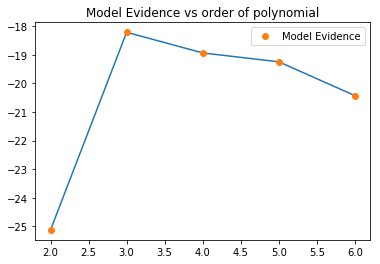

In [48]:
plt.plot(nPowers,Evidence,)
plt.plot(nPowers,Evidence,'o',label='Model Evidence')
#plt.plot(x,f,label='true process')
plt.title('Model Evidence vs order of polynomial')
plt.legend()

### Autmobile Bodily Injury Claims Data

Source: Insurance Research Council (IRC)

The data are automobile injury claims data using data from the Insurance Research Council (IRC), a division of the American Institute for Chartered Property Casualty Underwriters and the Insurance Institute of America. The data, collected in 2002, contains information on the gender of the claimant, attorney involvement, years of driving experience and the economic loss (LOSS, in thousands). A detailed description of the variables in the data is provided below:

- Attorney: Whether the claimant is represented by an attorney (=1 if yes and =0 if no)
- CLMSEX: Claimant’s gender (=1 if male and =0 if female 
- CLMAGE: Claimant’s age minus the age driving license was obtained
- LOSS: The claimant’s total economic loss (in thousands $)

For confidentiality issues we consider here a sample of  simulated data similar to that of a state is considered. 

The data are in the provided file 'automobileBI.csv'

In [55]:
Auto = pd.read_csv("automobileBI.csv") 
Auto.head()

,ATTORNEY,CLMSEX,CLMAGE,LOSS
0,1,0,1.8,6.38
1,0,0,5.6,0.95
2,1,1,1.4,1.88
3,0,1,5.4,0.11
4,1,0,0.9,6.95


In [56]:
Auto.describe()

,ATTORNEY,CLMSEX,CLMAGE,LOSS
count,1296.000000,1296.000000,1296.000000,1296.000000
mean,0.510802,0.423611,4.885571,4.616821
std,0.500076,0.494321,4.586972,7.570060
min,0.000000,0.000000,0.100000,0.010000
25%,0.000000,0.000000,1.700000,0.637500
50%,1.000000,0.000000,3.300000,2.000000
75%,1.000000,1.000000,6.600000,5.227500
max,1.000000,1.000000,31.300000,76.170000


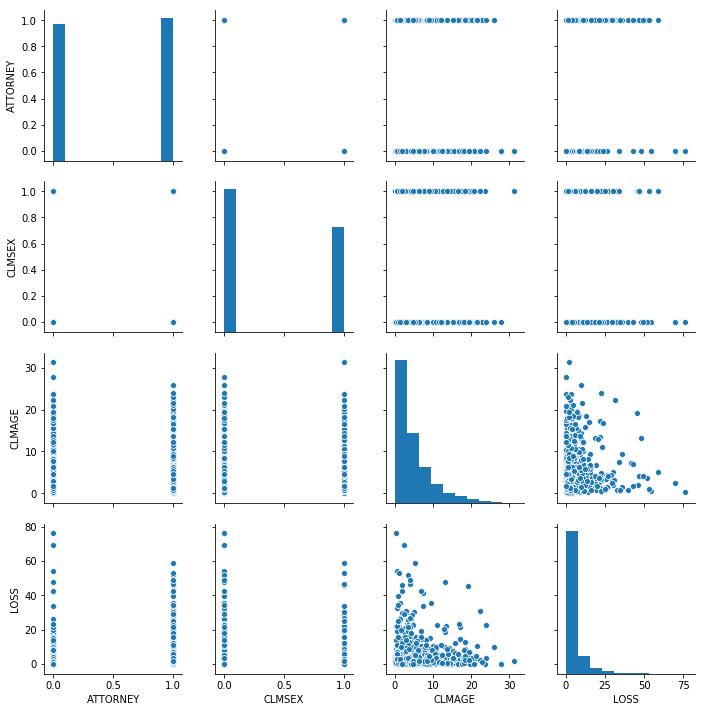

In [57]:
sns.pairplot(Auto)

### Activity 4

Consider all possible regression models with the LOSS variable as response and some (or all or none) of the other variables present (in their current form, no polynomials). There are 8 such models.

Calculate the model evidence for each of them, report the optimal one and present posterior estimates of its coefficients.

In [58]:
'''
The models are:
1. Intercept  only
2. Intercept & ATTORNEY
3. Intercept & CLMSEX
4. Int & CLMAGE
5. Int & ATTORNEY & CLMSEX
6. Int & ATTORNEY & CLMAGE
7. Int & CLMSEX & CLMAGE
8. Int & ATTORNEY & CLMSEX & CLMAGE
'''

#  across models
N = 1000 # Set Monte Carlo sample size
n = Auto.shape[0]
Auto['x0']=np.ones(n)
y = Auto['LOSS']
#Priors constant across models
a_0 = 0.01
b_0 = 0.01

In [59]:
# Model 1
predictors = ['x0']
X = Auto[predictors]

n,p = X.shape

#Prior depending on X
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior


results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
log_evid= ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
print(log_evid)   #M1 -4473
print(results)

-4472.5825294679325
    posterior mean  lower 95% bound  upper 95% bound
x0        4.613055         4.230882         5.020661


In [60]:
#Model 2
predictors = ['x0','ATTORNEY']
X = Auto[predictors]
n,p = X.shape

#Prior depending on X
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior


results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
log_evid= ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
print(log_evid)   #M1 -4430
print(results)

-4430.1549428468625
          posterior mean  lower 95% bound  upper 95% bound
x0              2.581852         2.019829         3.145757
ATTORNEY        3.953332         3.135377         4.773954


In [61]:
#Model 4
predictors = ['x0','CLMAGE']
X = Auto[predictors]
n,p = X.shape

#Prior depending on X
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior


results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
log_evid= ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
print(log_evid)   #M1 -4476
print(results) 

-4475.590802367424
        posterior mean  lower 95% bound  upper 95% bound
x0            4.850540         4.259956         5.457062
CLMAGE       -0.048817        -0.139180         0.043886


In [62]:
#Model 5
predictors = ['x0','ATTORNEY','CLMSEX']
X = Auto[predictors]
n,p = X.shape

#Prior depending on X
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior


results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
log_evid= ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
print(log_evid)   #M1 -4432
print(results)

-4431.685382148892
          posterior mean  lower 95% bound  upper 95% bound
x0              2.891845         2.267928         3.488291
ATTORNEY        4.052022         3.258218         4.887108
CLMSEX         -0.843267        -1.630359        -0.045298


In [63]:
#Model 6
predictors = ['x0','ATTORNEY','CLMAGE']
X = Auto[predictors]
n,p = X.shape

#Prior depending on X
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior


results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
log_evid= ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
print(log_evid)   #M1 -4434
print(results)

-4433.603522245847
          posterior mean  lower 95% bound  upper 95% bound
x0              2.705959         1.933842         3.402067
ATTORNEY        3.952687         3.184588         4.765091
CLMAGE         -0.022227        -0.113571         0.064630


In [64]:
#Model 7
predictors = ['x0','CLMSEX','CLMAGE']
X = Auto[predictors]
n,p = X.shape

#Prior depending on X
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior


results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
log_evid= ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
print(log_evid)   #M1 -4479
print(results)

-4478.94521453277
        posterior mean  lower 95% bound  upper 95% bound
x0            4.987319         4.302367         5.691765
CLMSEX       -0.288166        -1.124673         0.506856
CLMAGE       -0.051112        -0.137715         0.041517


In [65]:
#Model 8
predictors = ['x0','ATTORNEY','CLMSEX','CLMAGE']
X = Auto[predictors]
n,p = X.shape

#Prior depending on X
mu_0 = np.zeros(p)
XtX = X.T.dot(X)
Om_0_inv = XtX/n #unit information prior


results, mu_n, Om_n, a_n, b_n = BLR(X,y,mu_0,Om_0_inv,a_0,b_0,predictors,N)
log_evid= ModEvidence(X,y,mu_n,Om_n,mu_0,Om_0_inv,a_n,b_n,a_0,b_0)
print(log_evid)   #M1 -4435
print(results) 

-4435.085619416105
          posterior mean  lower 95% bound  upper 95% bound
x0              3.016817         2.274660         3.742762
ATTORNEY        4.097817         3.304448         4.893690
CLMSEX         -0.874560        -1.676544        -0.091043
CLMAGE         -0.025828        -0.105946         0.060769


Model 2 has the highest evidence (-4430). So information about gender does not appear to essential although model 5 (same as Model 2 but with gender as well) is not so bad (-4432).